In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/Workspace/data/emotion-recognition/archive.zip

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    
  inflating: train/sad/im3721.png    

In [2]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_ds_full = ImageFolder(root='train', transform=transform)
train_size = int(0.8 * len(train_ds_full))
val_size = len(train_ds_full) - train_size
train_ds, val_ds = random_split(train_ds_full, [train_size, val_size])

test_ds = ImageFolder(root='test', transform=transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

shape: torch.Size([1, 48, 48])


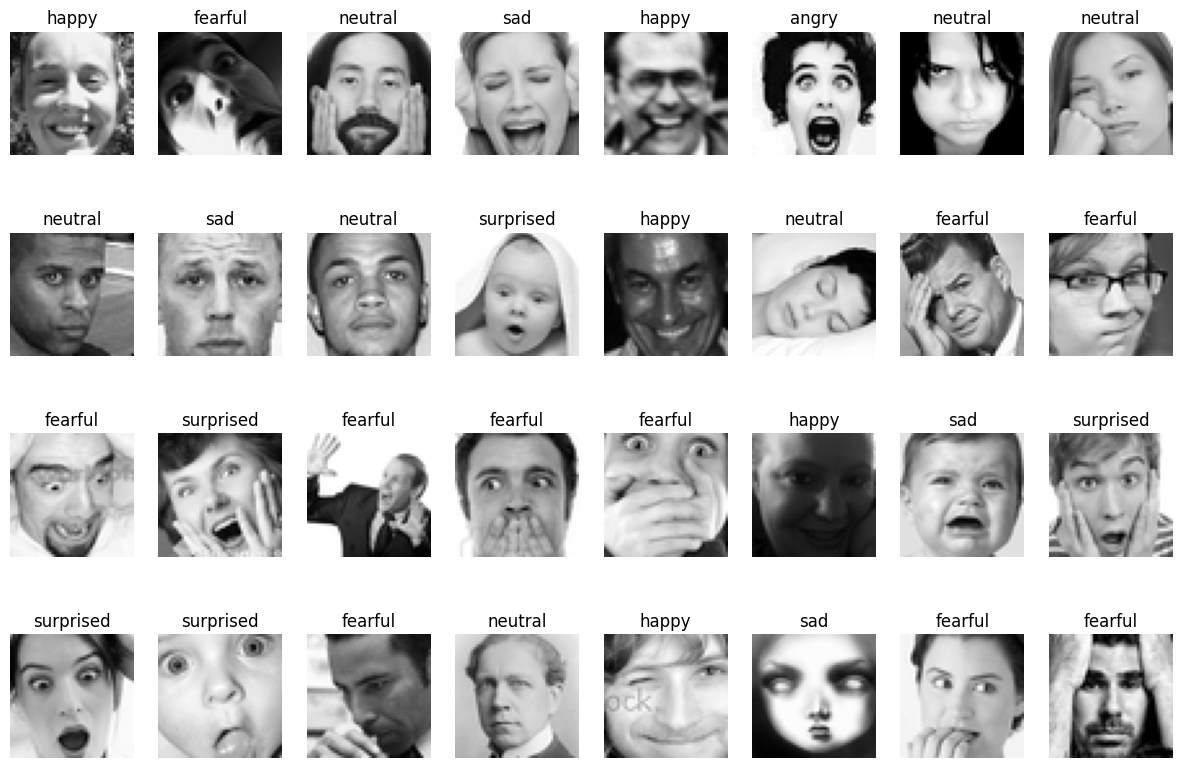

In [3]:
import matplotlib.pyplot as plt

for images, labels in train_dl:
  print('shape:', images[0].shape)

  fig, axes = plt.subplots(4, int(len(images)/4), figsize=(15,10))
  axes = axes.ravel()

  for i in range(len(images)):
    img = images[i].squeeze().numpy()
    label = train_ds_full.classes[labels[i].item()]

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')

  plt.show()

  break

shape: torch.Size([1, 48, 48])


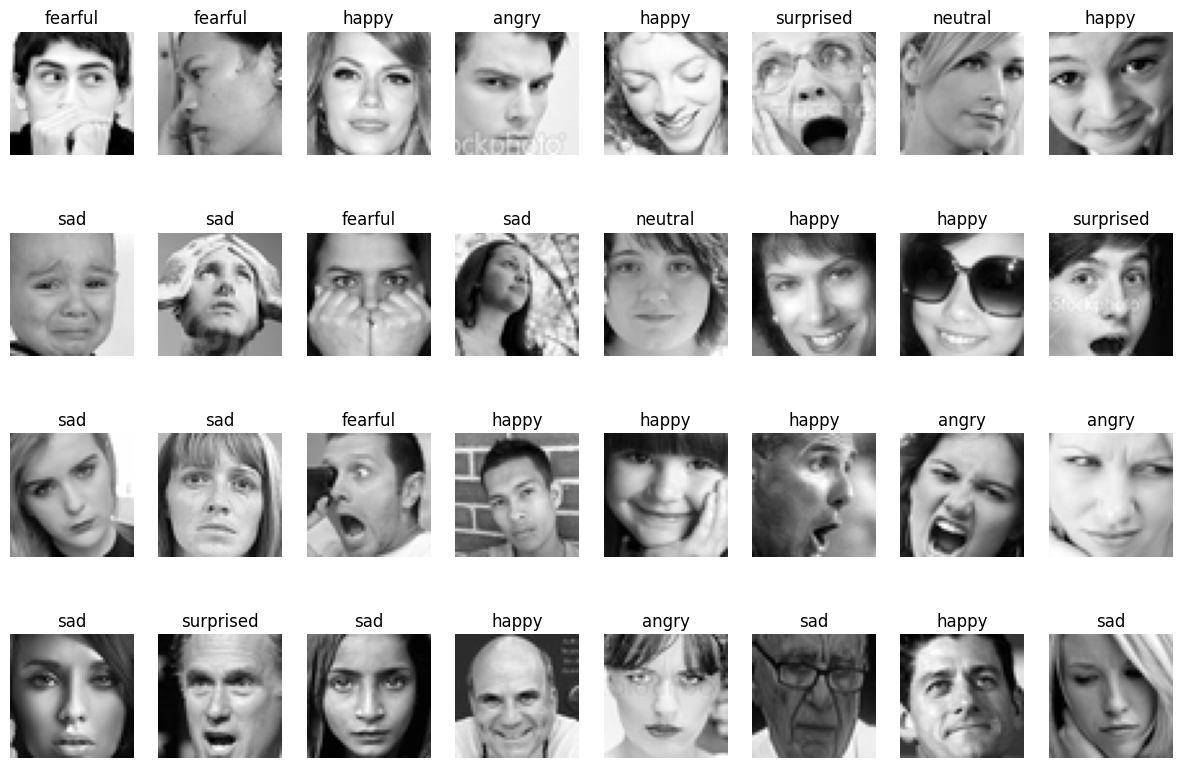

In [4]:
for images, labels in test_dl:
  print('shape:', images[0].shape)

  fig, axes = plt.subplots(4, int(len(images)/4), figsize=(15,10))
  axes = axes.ravel()

  for i in range(len(images)):
    img = images[i].squeeze().numpy()
    label = test_ds.classes[labels[i].item()]

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')

  plt.show()

  break

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

    self.fc1 = nn.Linear(16*9*9, 216)
    self.fc2 = nn.Linear(216, 152)
    self.fc3 = nn.Linear(152, 7)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2)

    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x



class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(128 * 12 * 12, 256)
    self.fc2 = nn.Linear(256, 7)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool(x)

    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

class DepthwiseSeperableConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    super(DepthwiseSeperableConv, self).__init__()

    self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
    self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.depthwise(x)
    x = self.pointwise(x)
    x = self.bn(x)

    return F.relu(x)

class MiniXception(nn.Module):
  def __init__(self):
    super(MiniXception, self).__init__()

    self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(8)

    self.dsconv1 = DepthwiseSeperableConv(8, 8, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(2)

    self.dsconv2 = DepthwiseSeperableConv(8, 16, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2)

    self.dsconv3 = DepthwiseSeperableConv(16, 32, kernel_size=3, stride=1, padding=1)
    self.pool3 = nn.MaxPool2d(2)

    self.dsconv4 = DepthwiseSeperableConv(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool4 = nn.MaxPool2d(2)

    self.fc = nn.Linear(64*3*3, 7)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.pool1(self.dsconv1(x))
    x = self.pool2(self.dsconv2(x))
    x = self.pool3(self.dsconv3(x))
    x = self.pool4(self.dsconv4(x))

    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

model = MiniXception().to(device)
print(model)

MiniXception(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dsconv1): DepthwiseSeperableConv(
    (depthwise): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
    (pointwise): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dsconv2): DepthwiseSeperableConv(
    (depthwise): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
    (pointwise): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dsconv3): DepthwiseSeperableConv(
    (depthwise): Conv2d(16, 16, kernel_s

In [10]:
from tqdm import tqdm

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
  model.train()
  train_loss = 0.0
  for images, labels in tqdm(train_dl, desc=f'Epoch {epoch+1} [Training]'):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_dl)

  model.eval()
  val_loss = 0.0

  with torch.no_grad():
    for images, labels in tqdm(val_dl, desc=f'Epoch {epoch+1} [Validation]'):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

    val_loss /= len(val_dl)

  print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

Epoch 1 [Validation]: 100%|██████████| 180/180 [00:02<00:00, 61.72it/s]


Epoch [1/10], Loss: 0.6384, Val Loss: 1.3274


Epoch 2 [Validation]: 100%|██████████| 180/180 [00:03<00:00, 50.20it/s]


Epoch [2/10], Loss: 1.1165, Val Loss: 1.3855


Epoch 3 [Validation]: 100%|██████████| 180/180 [00:02<00:00, 60.82it/s]


Epoch [3/10], Loss: 0.9380, Val Loss: 1.3347


Epoch 4 [Validation]: 100%|██████████| 180/180 [00:03<00:00, 55.00it/s]


Epoch [4/10], Loss: 0.9765, Val Loss: 1.3699


Epoch 5 [Validation]: 100%|██████████| 180/180 [00:03<00:00, 59.72it/s]


Epoch [5/10], Loss: 1.8305, Val Loss: 1.3626


Epoch 6 [Validation]: 100%|██████████| 180/180 [00:03<00:00, 59.78it/s]


Epoch [6/10], Loss: 1.6680, Val Loss: 1.3234


Epoch 7 [Validation]: 100%|██████████| 180/180 [00:04<00:00, 44.48it/s]


Epoch [7/10], Loss: 1.3286, Val Loss: 1.3244


Epoch 8 [Validation]: 100%|██████████| 180/180 [00:03<00:00, 59.66it/s]


Epoch [8/10], Loss: 1.8617, Val Loss: 1.3379


Epoch 9 [Validation]: 100%|██████████| 180/180 [00:02<00:00, 60.37it/s]


Epoch [9/10], Loss: 1.4509, Val Loss: 1.3357


Epoch 10 [Validation]: 100%|██████████| 180/180 [00:03<00:00, 48.37it/s]

Epoch [10/10], Loss: 1.5128, Val Loss: 1.3210


In [11]:
model.eval()
total_samples = 0
accurate_samples = 0
total_loss = 0.0

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    total_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    total_samples += labels.size(0)
    accurate_samples += (predicted == labels).sum().item()

  avg_loss = total_loss / len(test_dl)
  accuracy = 100.0 * accurate_samples / total_samples

  print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Test Loss: 1.3276, Test Accuracy: 50.85%
